<a href="https://colab.research.google.com/github/MathieuGrosso/machine-learning-/blob/main/extracting_features_MaterialData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import sys
import os
import functools
import pathlib
import pickle
from google.colab import drive

import numpy as np 

import functools
import pathlib
import pickle

import numpy as np
import pymicro
from pymicro.file import file_utils
import IPython
from IPython.display import clear_output
import matplotlib
from matplotlib import pyplot as plt, cm

from PIL import Image
from array import *
from random import shuffle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt, cm

import seaborn as sns
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc,roc_auc_score



# Save Data, load them and crops them 
inspired by the work of this notebook: "https://colab.research.google.com/drive/1J81JoRiq_GA8V0AfRWFySnccF08s4wfO#scrollTo=_0RughEUj0Rh"

In [2]:
%pip install pymicro

     |████████████████████████████████| 368kB 4.4MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

!ls

Mounted at /content/drive
drive  sample_data


In [4]:
%cd /content/drive/MyDrive/DIMA /Datasets/Data_big_raw
!cat pa66.raw.info

/content/drive/MyDrive/DIMA /Datasets/Data_big_raw
! PyHST_SLAVE VOLUME INFO FILE
NUM_X = 1300
NUM_Y = 1040
NUM_Z = 1900


In [5]:
import os
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from google.colab import files

src = list(files.upload().values())[0] 
open('read_raw.py','wb').write(src) 

from read_raw import HST_read


data_dir = Path("/content/drive/MyDrive/DIMA /Datasets/Data_big_raw").absolute()
sorted(os.listdir(data_dir))


Saving read_raw.py to read_raw (2).py


['128px-images-WITH-porosity',
 '128px-images-WITHOUT-porosity',
 '__pycache__',
 'pa66.ground_truth.raw',
 'pa66.ground_truth.raw.info',
 'pa66.raw',
 'pa66.raw.info',
 'pa66.test.error_volume.raw',
 'pa66.test.error_volume.raw.info',
 'pa66.test.prediction.raw',
 'pa66.test.prediction.raw.info',
 'read_raw (1).py',
 'read_raw (2).py',
 'read_raw.py']

In [6]:

data_dir = pathlib.Path('/content/drive/MyDrive/DIMA /Datasets/Data_big_raw') #changer la data_dir #grosse images
#data_dir=pathlib.Path('/content/drive/MyDrive/DIMA /Datasets/Data_reduced_raw') #petites images
data_filepath = (data_dir / "pa66.raw")
labels_filepath = data_dir / "pa66.ground_truth.raw"


In [9]:
# this is just a trick to give names to these values
# and put them together
class label:
    matrix = 0
    fiber = 1
    porosity = 2

labels_list = [0, 1, 2]

dimensions = (1300, 1040, 1900)
dtype = "uint8"

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

In [10]:
data = hst_read(data_filepath)
labels = hst_read(labels_filepath)

data type is uint8
volume size is 1300 x 1040 x 1900
reading volume... from byte 0
data type is uint8
volume size is 1300 x 1040 x 1900
reading volume... from byte 0


In [11]:
type(data), data.shape, data.dtype

(numpy.ndarray, (1300, 1040, 1900), dtype('uint8'))

In [12]:
type(labels), labels.shape, labels.dtype

(numpy.ndarray, (1300, 1040, 1900), dtype('uint8'))

In [13]:
assert data.shape == labels.shape

In [14]:
random_state = np.random.RandomState(42)

##Crops:

### Crops of data without porosity:

In [15]:
crop_size = 128  # 128 x 128 pixels square
n_crops = 1000
volume_shape = data.shape
axes_limits = (
    # x and y are smaller because i will get a random
    # coordinate of the left most and upper most pixel of the crop
    (0, volume_shape[0] - crop_size),  # x-axis
    (0, volume_shape[1] - crop_size),  # y-axis
    (0, volume_shape[2]),  # z-axis
)

In [16]:
# No Porosity: normal data
def does_not_have_porosity(label_crop_: np.ndarray) -> bool:
    return np.all(label_crop_ != label.porosity)

In [17]:
condition = does_not_have_porosity

In [18]:
print(f"found: 0")
crops = []

while len(crops) < n_crops:
    z = random_state.randint(*axes_limits[2])  # min / max in z
    x0 = random_state.randint(*axes_limits[0])
    y0 = random_state.randint(*axes_limits[1])
    x1, y1 = x0 + crop_size, y0 + crop_size
    
    labels_crop = labels[x0:x1, y0:y1, z]
    data_crop = data[x0:x1, y0:y1, z]
    
    if condition(labels_crop):
        crops.append({
            "data": data_crop.copy(),
            "labels": labels_crop.copy(),
        })
        clear_output()
        print(f"found: {len(crops)}")


found: 1000


In [19]:
without_porosity = crops

###Crops of data with porosity:

In [20]:
def has_porosity(label_crop_: np.ndarray) -> bool:
    return np.any(label_crop_ == label.porosity)

In [21]:
condition = has_porosity

In [22]:
print(f"found: 0")
crops = []

while len(crops) < n_crops:
    z = random_state.randint(*axes_limits[2])  # min / max in z
    x0 = random_state.randint(*axes_limits[0])
    y0 = random_state.randint(*axes_limits[1])
    x1, y1 = x0 + crop_size, y0 + crop_size
    
    labels_crop = labels[x0:x1, y0:y1, z]
    data_crop = data[x0:x1, y0:y1, z]
    
    if condition(labels_crop):
        crops.append({
            "data": data_crop.copy(),
            "labels": labels_crop.copy(),
        })
        clear_output()
        print(f"found: {len(crops)}")


found: 1000


In [23]:
with_porosity = crops

##Save Data in drive and Load them

In [24]:
len(without_porosity), len(with_porosity)

(1000, 1000)

In [25]:
without_porosity_folder = (data_dir / f"{crop_size}px-images-WITHOUT-porosity").resolve()
with_porosity_folder = (data_dir / f"{crop_size}px-images-WITH-porosity").resolve()

In [26]:
without_porosity_folder.mkdir(exist_ok=True)
with_porosity_folder.mkdir(exist_ok=True)

In [27]:
list_crops = without_porosity
folder = without_porosity_folder

In [28]:
for idx, crop in enumerate(list_crops):
    data_png_filepath = (folder / f"{idx:06d}-data.png")
    labels_png_filepath = (folder / f"{idx:06d}-labels.png")
    crop_data = crop["data"]
    crop_labels = crop["labels"]
    matplotlib.image.imsave(data_png_filepath, crop_data, cmap=cm.gray, vmin=0, vmax=255)    
    matplotlib.image.imsave(labels_png_filepath, crop_labels, cmap=cm.gray, vmin=0, vmax=2)   

In [29]:
list_crops = with_porosity
folder = with_porosity_folder

In [30]:
for idx, crop in enumerate(list_crops):
    data_png_filepath = (folder / f"{idx:06d}-data.png")
    labels_png_filepath = (folder / f"{idx:06d}-labels.png")
    crop_data = crop["data"]
    crop_labels = crop["labels"]
    matplotlib.image.imsave(data_png_filepath, crop_data, cmap=cm.gray, vmin=0, vmax=255)    
    matplotlib.image.imsave(labels_png_filepath, crop_labels, cmap=cm.gray, vmin=0, vmax=2)  

## Visualisation: 

In [31]:
list_of_examples = without_porosity

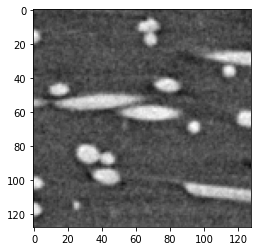

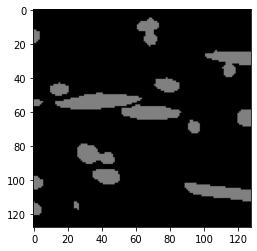

In [32]:
idx = 0

crop = list_of_examples[idx]
crop_data = crop["data"]
crop_labels = crop["labels"]

plt.figure()
plt.imshow(crop_data, cmap=cm.gray, vmin=0, vmax=255)

plt.figure()
plt.imshow(crop_labels, cmap=cm.gray, vmin=0, vmax=2);

In [33]:
list_of_examples = with_porosity

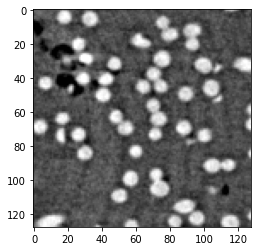

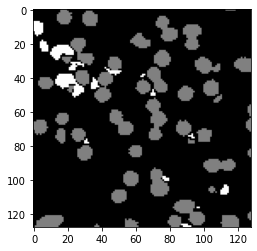

In [34]:
idx = 0

crop = list_of_examples[idx]
crop_data = crop["data"]
crop_labels = crop["labels"]

plt.figure()
plt.imshow(crop_data, cmap=cm.gray, vmin=0, vmax=255)

plt.figure()
plt.imshow(crop_labels, cmap=cm.gray, vmin=0, vmax=2);

#Preparation of the research: 

##Build the data for the training and testing set: 

In [36]:
# Load google drive and the file
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/DIMA /Datasets/Data_big_raw")
%cd /content/drive/MyDrive/DIMA /Datasets/Data_big_raw
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DIMA /Datasets/Data_big_raw
 128px-images-WITHOUT-porosity	 pa66.test.error_volume.raw.info
 128px-images-WITH-porosity	 pa66.test.prediction.raw
 pa66.ground_truth.raw		 pa66.test.prediction.raw.info
 pa66.ground_truth.raw.info	 __pycache__
 pa66.raw			'read_raw (1).py'
 pa66.raw.info			'read_raw (2).py'
 pa66.test.error_volume.raw	 read_raw.py


In [42]:
def create_data_set():
  
  data_dir = pathlib.Path(".").resolve()
  file_list = os.listdir(data_dir)
  file_list_train = {'x' : [], 'y' : []}
  file_list_test = {'x' : [], 'y' : []}

  for file_name in file_list:
      if file_name[-4:] == '.npy':
        key = file_name[-5]
        if 'train' in file_name:
          file_list_train[key].append(file_name)
        elif 'test' in file_name:
          file_list_test[key].append(file_name)
  
  train = {}
  test = {}

  for key in ['x', 'y']:
    train_path = (data_dir / file_list_train[key][0]).resolve()
    test_path = (data_dir / file_list_test[key][0]).resolve()
    train_data = np.load(train_path)
    test_data = np.load(test_path)
    train[key] = train_data
    test[key] = test_data

  if len(file_list_train) > 1:
    for key in ['x', 'y']:
      for i in range(len(file_list_train[key]) - 1):
        path = (data_dir / file_list_train[key][i+1]).resolve()
        data = np.load(path)
        train[key] = np.append(train[key], data, axis=0)

  if len(file_list_test) > 1:
    for key in ['x', 'y']:
      for i in range(len(file_list_test[key]) - 1):
        path = (data_dir / file_list_test[key][i+1]).resolve()
        data = np.load(path)
        test[key] = np.append(test[key], data, axis=0)

  randnum1 = np.random.randint(0,100)
  np.random.seed(randnum1)
  np.random.shuffle(train['x'])
  np.random.seed(randnum1)
  np.random.shuffle(train['y'])
  randnum2 = np.random.randint(0,100)
  np.random.seed(randnum2)
  np.random.shuffle(test['x'])
  np.random.seed(randnum2)
  np.random.shuffle(test['y'])

  train['x'] = train['x'].astype('float32') / 255
  test['x'] = test['x'].astype('float32') / 255
  train['x'] = np.expand_dims(train['x'], axis=3)
  test['x'] = np.expand_dims(test['x'], axis=3)

  return (train['x'],train['y']),(test['x'],test['y'])


<class 'numpy.ndarray'>
(16800, 32, 32, 1)
(16800,)
(0,)
(9600, 32, 32, 1)
(9600,)
(4800,)


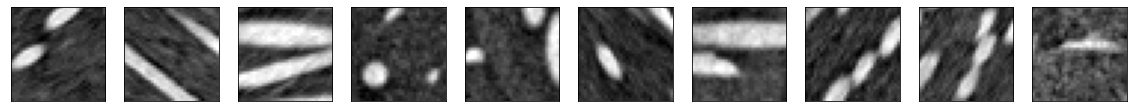

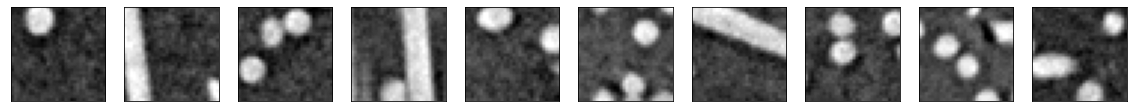

In [43]:
# Get the the training and the test dataset
(x_train, y_train), (x_test, y_test) = create_data_set()

print(type(x_train))
print(x_train.shape)
print(y_train.shape)
print(y_train[y_train==0].shape)
print(x_test.shape)
print(y_test.shape)
print(y_test[y_test==0].shape)

x_test_anormal = x_test[y_test==0]
# Display some NORMAL images
n = 10  # how many images we will display
plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_train[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test_anormal[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Class of our model

In [53]:
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
import numpy as np
import os

class MyModel():

  def construct_model(self,base_model,*liste,k,verbose=True):
    """create the model and then be able to update the level
    arguments:
        level : which blocks we decide to stop the backpropagation on
        base model:which pretrained model we use
        liste: the blocks on which we want to stop the backpropagation on 
        verbose = Boolean, if True, will print information about the models
    
    """
    self.base_model=base_model
    self.level=level
    self.verbose=verbose

    #build the model:
    self.input=base_model.input
    self.output=base_model.get_layer(liste[k]).output
    prev_model=Model(inputs=self.input,outputs=self.output)
    self.new_output=GlobalAveragePooling2D()
    model=sequential()
    self.model=model
    self.model.add(prev_model)
    self.model.add(self.new_output)
    if self.verbose:
        self.model.summary()



    

            
  def predict(self, data, verbose=1):
    return self.model.predict(x=data, verbose=verbose)

  def extract_features():
    return 

  def save(self,model,level, path):
    self.model=self.model.save("model"+str(self.level))

  def load(self,model, level, path, verbose=True):
    self.model=keras.models.load_model("model"+str(self.level))
    if verbose:
      self.summary()


## functions for evaluating the performance and to asses the distance 

In [69]:
from sklearn.covariance import EmpiricalCovariance
def mae(x1, x2):
    """Mean absolute error"""
    abs_diff = np.sum(np.abs(x1 - x2))
    abs_diff = abs_diff/(32*32)
    return abs_diff

def mae_n(x1, x2):
    """Normalized mean absolute error"""
    abs_diff = np.sum(np.abs(x1 - x2)) / np.sum(x1 + x2)
    return abs_diff/(32*32)

def cos_similarity(x1, x2):
    """Cosine simularity"""
    abs_diff = np.sum(np.multiply(x1, x2))/np.linalg.norm(x1, axis=None)/np.linalg.norm(x2, axis=None)
    return abs_diff

def distance_in_latent_space_vae(x1, x2, target_vae):
    vae = target_vae
    if len(x1.shape) < 4:
      x1 = np.expand_dims(x1, axis=0)
      x2 = np.expand_dims(x2, axis=0)
    _, _, z1 = vae.encoder.predict(x1, batch_size=1)
    _, _, z2 = vae.encoder.predict(x2, batch_size=1)
    distance = np.linalg.norm(z1 - z2)
    return distance

def distance_in_latent_space_ae(x1, x2, target_ae):
    ae = target_ae
    if len(x1.shape) < 4:
      x1 = np.expand_dims(x1, axis=0)
      x2 = np.expand_dims(x2, axis=0)
    z1 = ae.encoder.predict(x1, batch_size=1)
    z2 = ae.encoder.predict(x2, batch_size=1)
    distance = np.linalg.norm(z1 - z2, axis=1)
    return distance

def anomaly_detect_reconstruction(image, target_vae, distance_function, threshold=None):
    if len(image.shape) < 4:
        image = np.expand_dims(image, axis=0)
    image_decoded = target_vae.predict(image, batch_size=1)
    anomaly_score = distance_function(image, image_decoded)
    if threshold is None:
        return anomaly_score
    else:
        return anomaly_score - threshold

def anomaly_detect_latent(image, target_ae, threshold=None):
    if len(image.shape) < 4:
        image = np.expand_dims(image, axis=0)
    image_decoded = target_ae.predict(image, batch_size=1)
    anomaly_score = distance_in_latent_space_ae(image, image_decoded, target_ae)
    if threshold is None:
        return anomaly_score
    else:
        return anomaly_score - threshold

#mahalanobis distance: 
def anomaly_detect_mahalanobis(x_train_features,x_test_features,threshold=None):
  emp_cov=EmpiricalCovariance().fit(x_train_features)
  anomaly_score=np.log(emp_cov.mahalanobis(x_test_features))
  return anomaly_score


def plot_AUC(fpr,tpr,AUC):
    lw = 2
    plt.plot(fpr, tpr, 'o',color='darkorange', label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid('on')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def get_top_x_test(top_type, errs, k=10):
    max_error_index = np.argpartition(errs,-k)[-k:]
    min_error_index = np.argpartition(errs,k)[:k]
    x_most_normal = x_test[min_error_index]
    x_most_anormal = x_test[max_error_index]
    if top_type == 'normal':
        return x_most_normal
    else:
        return x_most_anormal

## functions for simplyfying the notebook

# Individual study 
trying our code on one specific example. 

##Find the feature map 

In [49]:

#loading the EfficientNet model: 
from tensorflow.keras.applications import EfficientNetB4
base_model = EfficientNetB4(weights='imagenet',include_top=False)
#print(base_model.summary()) #remove '#' to see what is written

71688192/71686520 [==============================] - 1s 0us/step


In [58]:
#initialize a model: 
#level 1 model 


from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
import numpy as np
import os

liste=['input_1','block1b_add','block2d_add','block3d_add','block4f_add','block5f_add','block6h_add','block7b_add']


#modifier le numéro dans list[] pour changer le block créé
prev_model=Model(inputs=base_model.input, outputs=base_model.get_layer(liste[1]).output) #loading the 1st block of the previously saved model 
#print(prev_model.summary())

block1_pool_features = Sequential()
block1_pool_features.add(prev_model)
block1_pool_features.add(GlobalAveragePooling2D())
block1_pool_features.compile()

block1_pool_features.summary()

x_train_features=block1_pool_features.predict(x_train)
x_test_features=block1_pool_features.predict(x_test)
print(block1_train_features.shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, None, None, 24)    5881      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 24)                0         
Total params: 5,881
Trainable params: 5,538
Non-trainable params: 343
_________________________________________________________________
(16800, 24)


## analyse et distance de mahalanobis

In [70]:
#mahalanobis distance: 

anomaly_detect_mahalanobis(x_train_features=x_train_features,x_test_features=x_test_features)

array([9.04483045, 9.0367272 , 9.03688758, ..., 9.04386049, 9.04230022,
       9.02423365])